<a href="https://colab.research.google.com/github/bhatmohit/Financial_Statement_Analysis/blob/main/Financial_misstatements_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [1]:
# Relevant libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm

# We need this one to load our data
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# Load Data
df = pd.read_pickle('drive/MyDrive/Financial_Statement_Analysis/Data/FSAData.pkl')

# Data Preparation

**Variables used for Regression Models:** <br/>
1) Indicator variable for **internal control weaknesses** (icw): If the auditor stated that the firm has internal control weaknesses, then it is more likely that something could have gone wrong in preparing this year's financial statements and as such should increase the probability of future restatements. <br/>
2) **Firm size**: The smaller the firm, the more likely it is that they do not have good controls in place to ensure the accuracy of the information included in the financial statements. <br/>
3) **Accruals**: Given that the management has a great flexibility in many of its estimates for accruals, potentially higher accruals could imply more aggressive accounting. <br/>
4) **Revenue growth**: The faster the company grows, the more likely is that the company may have an error in its financial statements as it has less time to properly grow its accounting department. Also, higher incentives to keep the growth coming which may result in more "aggressive" accounting that will result in a restatement.

In [3]:
df = (df.sort_values(by=['gvkey', 'fyear'])
           # Calculate relevant vars
           .assign(accruals=lambda x: (x['ni'] - x['oancf']) / x['at'],
                   log_at=lambda x: np.log(x['at']),
                   revt_py=lambda x: np.where( (x['gvkey'].shift(1) == x['gvkey']) &
                                               (x['fyear'].shift(1) + 1 == x['fyear']),
                                               x['revt'].shift(1), np.nan),
                   revt_gr=lambda x: (x['revt'] - x['revt_py']) / x['revt_py'] )
          )

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Data Cleaning

In [6]:
df = df.filter(['gvkey', 'fyear', 'restated', 'icw', 'log_at', 'accruals', 'revt_gr'])
           # Replace infinite values with missing values
df = df.replace([-np.inf, np.inf], np.nan)
           # Drop missing values
df = df.dropna()

df.head()

,gvkey,fyear,restated,icw,log_at,accruals,revt_gr
13,001004,2004.0,0.0,0.0,6.596095,-0.048462,0.147080
14,001004,2005.0,0.0,0.0,6.886347,0.077282,0.199821
15,001004,2006.0,0.0,0.0,6.973199,0.074838,0.182646
16,001004,2007.0,0.0,0.0,7.216717,0.042744,0.305088
17,001004,2008.0,0.0,0.0,7.228034,0.010308,0.028202


## Winsorization

In [7]:
def winsorize(input_data):

    # Calculates the 1st percentile value and saves it in q1
    q1 = input_data.quantile(0.01)
    # Calculates the 99th percentile value and saves it in q99
    q99 = input_data.quantile(0.99)

    # Replace extreme values
    input_data = np.where(input_data < q1, q1, input_data)
    input_data = np.where(input_data > q99, q99, input_data)

    # Return data
    return input_data

df = (df.assign(log_at_w=lambda x: winsorize(x['log_at']),
                   accruals_w=lambda x: winsorize(x['accruals']),
                   revt_gr_w=lambda x: winsorize(x['revt_gr'])))

# Ordinary Least Square Regression
Build Model

In [8]:
ols_model = sm.formula.ols('restated ~ icw + log_at_w + accruals_w + revt_gr_w', data=df).fit()
print(ols_model.summary2())

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.009     
Dependent Variable: restated         AIC:                11667.1993
Date:               2023-08-06 06:17 BIC:                11709.7371
No. Observations:   36591            Log-Likelihood:     -5828.6   
Df Model:           4                F-statistic:        80.26     
Df Residuals:       36586            Prob (F-statistic): 6.29e-68  
R-squared:          0.009            Scale:              0.080527  
--------------------------------------------------------------------
                 Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
--------------------------------------------------------------------
Intercept        0.1507    0.0082  18.2723  0.0000   0.1345   0.1669
icw              0.1288    0.0084  15.3190  0.0000   0.1124   0.1453
log_at_w        -0.0078    0.0009  -8.3931  0.0000  -0.0096  -0.0060
accruals_w       0.0113    0.0221   0.5106  0.6096  -0.0321 

Make Predictions

In [9]:
df['ols_probability'] = ols_model.predict(df)

df.head()

,gvkey,fyear,restated,icw,log_at,accruals,revt_gr,log_at_w,accruals_w,revt_gr_w,ols_probability
13,001004,2004.0,0.0,0.0,6.596095,-0.048462,0.147080,6.596095,-0.048462,0.147080,0.098272
14,001004,2005.0,0.0,0.0,6.886347,0.077282,0.199821,6.886347,0.077282,0.199821,0.097282
15,001004,2006.0,0.0,0.0,6.973199,0.074838,0.182646,6.973199,0.074838,0.182646,0.096624
16,001004,2007.0,0.0,0.0,7.216717,0.042744,0.305088,7.216717,0.042744,0.305088,0.094020
17,001004,2008.0,0.0,0.0,7.228034,0.010308,0.028202,7.228034,0.010308,0.028202,0.094335


In [10]:
df[['ols_probability', 'restated']].describe().round(3)

,ols_probability,restated
count,36591.000,36591.000
mean,0.089,0.089
std,0.027,0.285
min,0.044,0.000
25%,0.078,0.000
50%,0.087,0.000
75%,0.095,0.000
max,0.240,1.000


# Logistic Regression
Build Model

In [11]:
logit_model = sm.formula.logit('restated ~ icw + log_at_w + accruals_w + revt_gr_w', data=df).fit()
print(logit_model.summary2())

Optimization terminated successfully.
         Current function value: 0.297086
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.012     
Dependent Variable: restated         AIC:              21751.3604
Date:               2023-08-06 06:18 BIC:              21793.8982
No. Observations:   36591            Log-Likelihood:   -10871.   
Df Model:           4                LL-Null:          -11000.   
Df Residuals:       36586            LLR p-value:      7.6387e-55
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
              Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept    -1.5375    0.1037  -14.8239  0.0000  -1.7407  -1.3342
icw           1.0531    0.0735   14.3329  0.0000   0.9091   1.

In [12]:
df['logit_probability'] = logit_model.predict(df)

df[['logit_probability', 'restated']].describe().round(3)

,logit_probability,restated
count,36591.000,36591.000
mean,0.089,0.089
std,0.027,0.285
min,0.052,0.000
25%,0.077,0.000
50%,0.086,0.000
75%,0.094,0.000
max,0.270,1.000


# Model Evaluation

In [13]:
# Predict positive if among the top 10% in probability
df = (df.assign(
                # for ols model
                ols_cutoff=lambda x: x['ols_probability'].quantile(0.9),
                ols_pred_restated=lambda x: np.where(x['ols_probability'] >= x['ols_cutoff'], 1, 0),
                # for logit model
                logit_cutoff=lambda x: x['logit_probability'].quantile(0.9),
                logit_pred_restated=lambda x: np.where(x['logit_probability'] >= x['logit_cutoff'], 1, 0),
               )
     )

# df.groupby(['ols_pred_restated'])['ols_probability'].describe().round(3)

## Precision

In [15]:
# Precision --- Among those classified as likely to restate, how many did indeed restate?
ols_prec_df = (df
           # Keep firms classified as likely to restate
           .query('ols_pred_restated == 1')
           # Keep relevant columns
           .filter(['gvkey', 'fyear', 'ols_pred_restated', 'restated'])
          )

logit_prec_df = (df
           # Keep firms classified as likely to restate
           .query('logit_pred_restated == 1')
           # Keep relevant columns
           .filter(['gvkey', 'fyear', 'logit_pred_restated', 'restated'])
          )

# print('Precision:')
ols_precision = ols_prec_df['restated'].mean()

logit_precision = logit_prec_df['restated'].mean()
print(ols_precision)
print(logit_precision)

0.1355191256830601
0.13497267759562842


## Sensitivity

In [17]:
# Sensitivity --- Among restated firms, how many did we correctly identify?

ols_sens_df = (df
           # Keep first that actuall restate
           .query('restated == 1')
           # Keep relevant columns
           .filter(['gvkey', 'fyear', 'ols_pred_restated', 'restated'])
          )

logit_sens_df = (df
           # Keep first that actuall restate
           .query('restated == 1')
           # Keep relevant columns
           .filter(['gvkey', 'fyear', 'logit_pred_restated', 'restated'])
          )


ols_sensitivity = ols_sens_df['ols_pred_restated'].mean()
logit_sensitivity = logit_sens_df['logit_pred_restated'].mean()

print(ols_sensitivity)
print(logit_sensitivity)

0.1520073551946062
0.15139442231075698


## AUROC

In [18]:
from sklearn.metrics import roc_auc_score

roc_auc_score(df['restated'], df['logit_probability'])

0.5667767277946819

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve

fpr, tpr, threshold = roc_curve(df['restated'],  df['logit_probability'])

<ipython-input-20-d26b1acd3ed7>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=fpr, y=tpr, ci=None)


<Figure size 640x480 with 0 Axes>

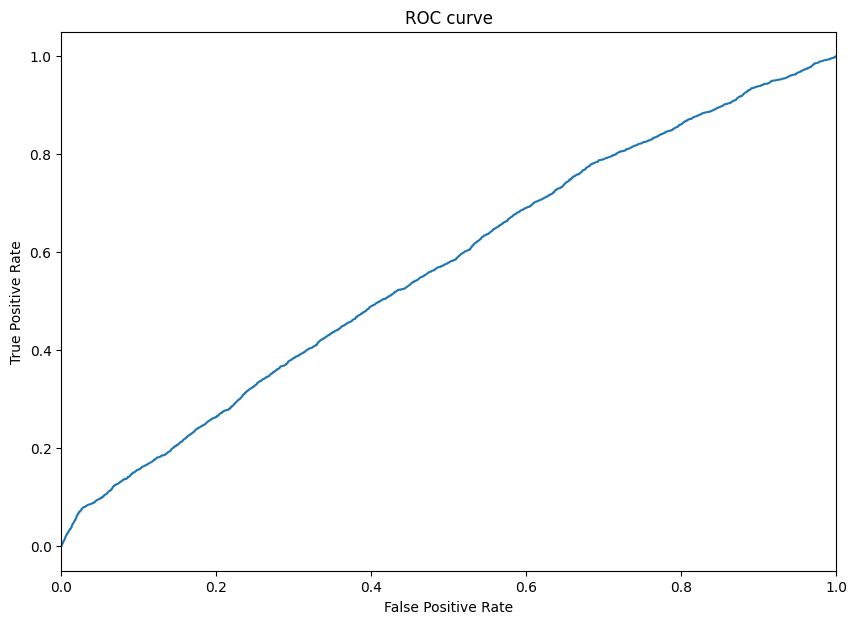

In [20]:
plt.clf()
plt.figure(figsize=(10,7))
sns.lineplot(x=fpr, y=tpr, ci=None)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
# So there is no extra empty padding on the sides of the graph
plt.margins(x=0)
plt.show()

In [21]:
roc_curve(df['restated'],  df['logit_probability'])

(array([0.00000000e+00, 3.00048008e-05, 1.20019203e-04, ...,
        9.99519923e-01, 9.99519923e-01, 1.00000000e+00]),
 array([0.        , 0.        , 0.        , ..., 0.99969353, 1.        ,
        1.        ]),
 array([1.27006083, 0.27006083, 0.26799573, ..., 0.05329084, 0.05326857,
        0.05161173]))

In [22]:
# false positive rates, true positive rates, threshold
df1 = pd.DataFrame(np.transpose(roc_curve(df['restated'],  df['logit_probability'])), columns=['FPR', 'TPR', 'Threshold'])
df1

,FPR,TPR,Threshold
0,0.00000,0.000000,1.270061
1,0.00003,0.000000,0.270061
2,0.00012,0.000000,0.267996
3,0.00012,0.000306,0.265971
4,0.00021,0.000306,0.265683
...,...,...,...
5869,0.99865,0.999081,0.053585
5870,0.99865,0.999694,0.053554
5871,0.99952,0.999694,0.053291
5872,0.99952,1.000000,0.053269


In [24]:
#keep observations with probability score equal or higher to 0.265971 (row 4 above) as that is the first time that both the FPR and the TPR columns are larger than 0.
(df
 .query('logit_probability >= 0.265971')
 .sort_values(by=['logit_probability'], ascending=False)
)

,gvkey,fyear,restated,icw,log_at,accruals,revt_gr,log_at_w,accruals_w,revt_gr_w,ols_probability,logit_probability,ols_cutoff,ols_pred_restated,logit_cutoff,logit_pred_restated
69734,176594,2012.0,0.0,1.0,5.071586,0.011905,-0.299680,5.175746,0.011905,-0.299680,0.240126,0.270061,0.101852,1,0.102579,1
15706,007124,2012.0,0.0,1.0,5.173162,0.047146,0.012377,5.175746,0.047146,0.012377,0.239656,0.268829,0.101852,1,0.102579,1
57797,065421,2005.0,0.0,1.0,4.809318,0.094441,0.294475,5.175746,0.094441,0.294475,0.239407,0.268145,0.101852,1,0.102579,1
72350,187653,2015.0,0.0,1.0,5.186419,0.190458,0.463887,5.186419,0.139950,0.463887,0.239367,0.267996,0.101852,1,0.102579,1
69386,175503,2013.0,1.0,1.0,4.521452,-0.071307,-0.045601,5.175746,-0.071307,-0.045601,0.238478,0.265971,0.101852,1,0.102579,1


In [25]:
df['restated'].value_counts()

0.0    33328
1.0     3263
Name: restated, dtype: int64

## Results
33,328 observations that did not restate and 3,263 that did